# NLP Disaster Tweets Kaggle Mini-Project
**GitHub Repository**: https://github.com/ilichenko/DTSA-5511

Useful guide on how to install TensorFlow in Jupyter Notebook: https://how.dev/answers/how-to-install-tensorflow-in-jupyter-notebook

## 1. Introduction
### 1.1. Problem Statement
This study involves analyzing short messages posted on Twitter and predicting whether they refer to real disasters. Tweets that are actual disaster reports should be classified as `1`, while irrelevant or sarcastic mentions should be labeled `0`. This problem is framed as a binary classification task.

### 1.2. Study Objective
The primary objective is to evaluate and compare machine learning models for textual data. We aim to construct a reliable classifier that can predict the target label with strong generalization ability.

### 1.3. Dataset Overview
The dataset contains the following:
- **train.csv**: Labeled training tweets with binary target values.
- **test.csv**: Unlabeled tweets for which predictions are required.
  
Each record includes the tweet text, keyword (if any), and the location of the tweet's origin.

## 2. Exploratory Data Analysis (EDA)

The following code installs the required libraries and imports the data:

In [1]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from pathlib import Path
from urllib.parse import unquote

In [68]:
TRAIN_PATH = Path("train.csv")
TEST_PATH = Path("test.csv")

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print('Training set shape:', train_df.shape)
print('Test set shape:', test_df.shape)

train_df.head(20)

Training set shape: (7613, 5)
Test set shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


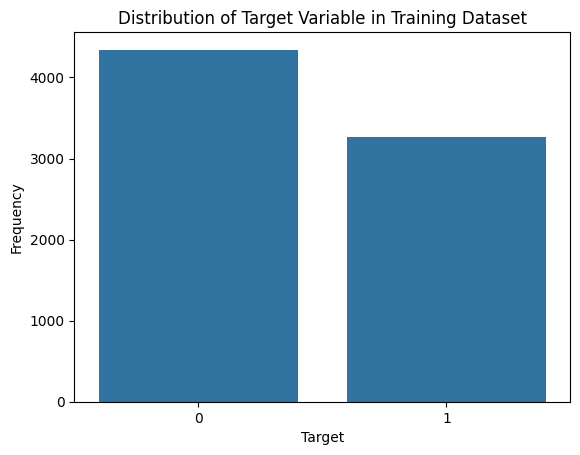

In [3]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

The training dataset appears balanced; however, we observed some missing values and considerable noise in the `text` data. Therefore, we proceed with data preprocessing.

## 3. Data Preprocessing

We start with the investigation on the null values in both, train and test datasets:

In [4]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [69]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

We drop rows with missing `keyword` since it's true for less than 1% of data. For `location`, we replace NaN values with *missing*. Since we also expect `location` values to be noisy, we strip whitespaces:

In [70]:
train_df = train_df[~train_df['keyword'].isna()].reset_index(drop=True)
# test_df = test_df[~test_df['keyword'].isna()].reset_index(drop=True)

train_df['location'] = train_df['location'].fillna('missing')
train_df['location'] = train_df['location'].str.strip()

# test_df['location'] = test_df['location'].fillna('missing')
# test_df['location'] = test_df['location'].str.strip()

While analyzing the train and test datasets, we observe encoding issues in some of the location entries. To address this, we normalize the data to ensure consistent formatting and correct any character encoding anomalies:

In [7]:
_df = train_df[train_df.apply(lambda row: row.astype(str).str.contains('%20').any(), axis=1)]
_df.head(5)

,id,keyword,location,text,target
105,196,airplane%20accident,"19.600858, -99.047821",Experts in France begin examining airplane deb...,1
106,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
107,198,airplane%20accident,"Salt Lake City, Utah",@crobscarla your lifetime odds of dying from a...,0
108,199,airplane%20accident,"Palo Alto, CA",Experts in France begin examining airplane deb...,1
109,201,airplane%20accident,missing,@AlexAllTimeLow awwww they're on an airplane a...,1


In [71]:
import re 

def normalize(text):
    if pd.isnull(text):
        return text
    text = unicodedata.normalize('NFKD', str(text))
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    text = unquote(text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

train_df['keyword'] = train_df['keyword'].apply(normalize)
test_df['keyword'] = test_df['keyword'].apply(normalize)

train_df['location'] = train_df['location'].apply(normalize)
test_df['location'] = test_df['location'].apply(normalize)

train_df['text'] = train_df['text'].apply(normalize)
test_df['text'] = test_df['text'].apply(normalize)

We continue to standardize the `location` data. Checking the numbers of unique locations in both datasets, we can observe that the data is noisy:

In [9]:
print(train_df['location'].nunique())
print(test_df['location'].nunique())

3278
1586


Next steps:
- we handle different namings of the same locations, e.g. *USA*, *US* and *United States*, or *Everywhere* and *World* using the predefined mapping;
- since we have locations defined as cities, states and countries, we map all cities, states and coordinates to countries to reduce noise and variance in data:

In [10]:
with open('countries_mapping.txt', 'r') as file:
    content = file.read()

location_to_country = ast.literal_eval(content)

In [72]:
train_df['location'] = train_df['location'].replace(location_to_country)
test_df['location'] = test_df['location'].replace(location_to_country)

In [12]:
location_counts_train_df = train_df['location'].value_counts()
locations_train_df = location_counts_train_df.reset_index()
locations_train_df.columns = ['Location', 'Count']
locations_train_df.head()

,Location,Count
0,missing,2839
1,USA,1442
2,UK,267
3,Canada,126
4,Global,89


In [13]:
location_counts_test_df = test_df['location'].value_counts()
locations_test_df = location_counts_test_df.reset_index()
locations_test_df.columns = ['Location', 'Count']
locations_test_df.head()

,Location,Count
0,missing,1253
1,USA,751
2,UK,130
3,Canada,84
4,India,40


A reassessment of the `location` data reveals that our cleaning efforts have significantly mitigated noise; however, additional refinement will likely yield further improvements:

In [73]:
print(train_df['location'].nunique())
print(test_df['location'].nunique())

2235
753


We plot the preprocessed data taking traning dataset as an example:

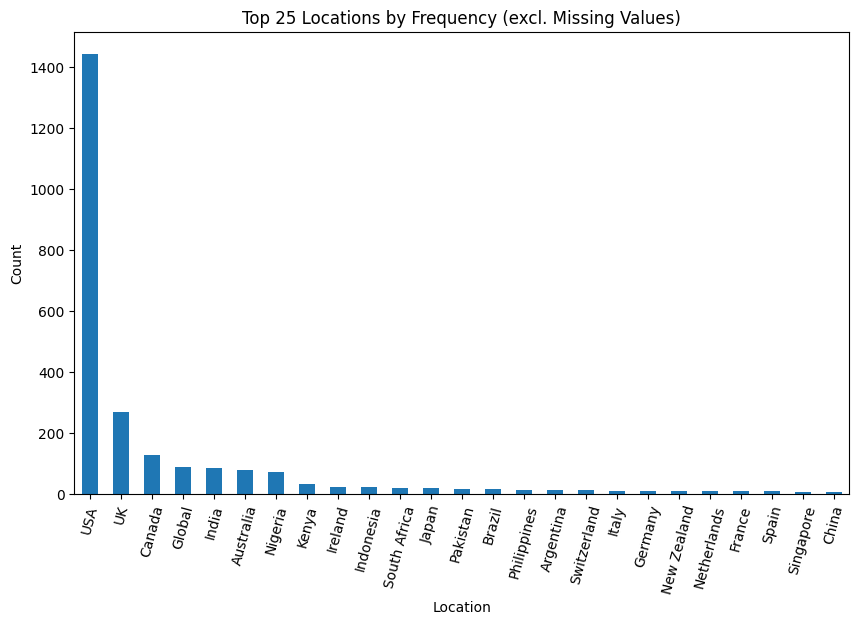

In [15]:
plt.figure(figsize=(10, 6))
train_df[train_df['location'] != "missing"]['location'].value_counts().head(25).plot(kind='bar')

plt.title('Top 25 Locations by Frequency (excl. Missing Values)')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

Next, we clean and simplify text data by fixing contractions, removing URLs, usernames, hashtags, and non-letter characters, then converting everything to lowercase. Afterwards, we split the text into words, remove common stop words, and reduce words to their base forms using lemmatization. Finally, we apply this cleaning process to all text entries in the train and test datasets, creating new columns with the processed text for further analysis:

In [63]:
# import sys
# !{sys.executable} -m pip install --upgrade contractions
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaroslavilichenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yaroslavilichenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yaroslavilichenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yaroslavilichenko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [74]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = contractions.fix(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['text_preprocessed'] = train_df['text'].apply(preprocess)
test_df['text_preprocessed'] = test_df['text'].apply(preprocess)
train_df[['text', 'text_preprocessed']].head()

,text,text_preprocessed
0,@bbcmtd Wholesale Markets ablaze http://t.co/l...,wholesale market ablaze
1,We always try to bring the heavy. #metal #RT h...,always try bring heavy
2,#AFRICANBAZE: Breaking news:Nigeria flag set a...,breaking newsnigeria flag set ablaze aba
3,Crying out for more! Set me ablaze,cry set ablaze
4,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,plus side look sky last night ablaze


Now we examine the top 20 keywords for each target class separately. We observe that all the keywords are clean and well-formatted, with no noticeable inconsistencies:

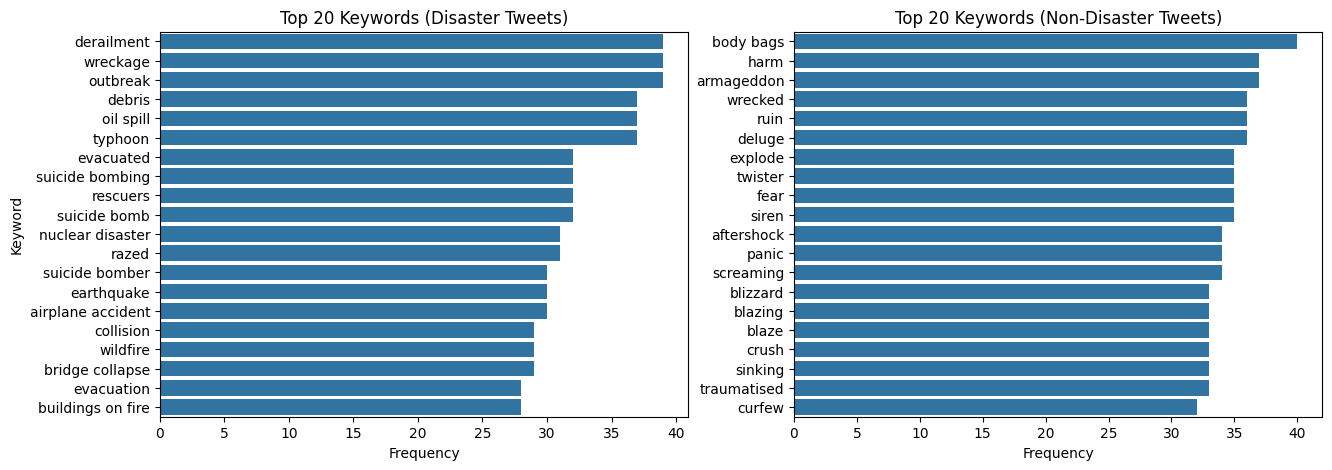

In [18]:
top_keywords_target1 = train_df[train_df['target']==1]['keyword'].value_counts().head(20)
top_keywords_target0 = train_df[train_df['target']==0]['keyword'].value_counts().head(20)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(x=top_keywords_target1.values, y=top_keywords_target1.index, ax=axs[0])
axs[0].set_title('Top 20 Keywords (Disaster Tweets)')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Keyword')

sns.barplot(x=top_keywords_target0.values, y=top_keywords_target0.index, ax=axs[1])
axs[1].set_title('Top 20 Keywords (Non-Disaster Tweets)')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('')

plt.show()

## 4. Model Building
After we preprocessed the data, we can start building the models. To start with, we define our initial training parameters and then build our first model using TF-IDF features with Logistic Regression:

In [20]:
VOCABULARY_SIZE = 10000
MAX_ITER = 1000
MAX_INPUT_LENGTH = 100
EMBEDDING_DIMENSION = 100

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_tfidf = train_df['text_preprocessed']
y_tfidf = train_df['target']
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_tfidf, y_tfidf, test_size = 0.2, random_state = 7)

tfidf = TfidfVectorizer(max_features = VOCABULARY_SIZE, ngram_range = (1,2))
X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
X_val_tfidf = tfidf.transform(X_val_tfidf)

lr = LogisticRegression(max_iter = MAX_ITER)

In the next step, we build two models: one using LSTM (Long Short-Term Memory) and the other using GRU (Gated Recurrent Unit) for comparison. As a preparation step, we define a tokenizer and fit it on the preprocessed text, assigning integer IDs to each word based on their frequency. Then, we convert each sentence into a list of these word indices. Finally, we pad all sequences to ensure they have the same length, which is required for feeding them into neural network models. Next, we define the following layers for our models:
- **Embedding layer** transforms tokens into dense vectors.
- **LSTM/GRU layer** captures sequence dependencies. We use *bidirectional* so LSTM and GRU process the sequences both forward and backward to better understand the sentence structure. We also utilize 64 memory units in one direction, i.e. 128 in total. We also define `dropout`, which cuts some incoming signals from the embedding or previous layer, and `recurrent_dropout`, which cuts some of the LSTM’s memory links during its step-by-step sequence processing – both will help us to prevent overfitting.
- **Dense layers** serve as fully connected decision layers. The final `Dense(1, activation='sigmoid')` outputs a probability for binary classification.

In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(train_df['text_preprocessed'])

X_lg = tokenizer.texts_to_sequences(train_df['text_preprocessed'])
X_lg = pad_sequences(X_lg, maxlen=MAX_INPUT_LENGTH)
y_lg = train_df['target'].values

X_train_lg, X_val_lg, y_train_lg, y_val_lg = train_test_split(X_lg, y_lg, test_size=0.2, random_state=7)

def build_lstm_model(input_length):
    model = models.Sequential([
        layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSION),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

lstm_model = build_lstm_model(MAX_INPUT_LENGTH)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])


def build_gru_model(input_length):
    model = models.Sequential([
        layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSION),
        layers.Bidirectional(layers.GRU(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

gru_model = build_gru_model(MAX_INPUT_LENGTH)
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

Our final model is built using BERT (Bidirectional Encoder Representations from Transformers), i.e. the **bert-base-en-uncased** version, which is trained on lowercased English text, has 12 layers, and contains 110 million parameters. BERT is an open source machine learning framework for NLP. BERT was developed to help computers understand the meaning of ambiguous language in texts by using the surrounding text to provide context. This makes it particularly valuable for our study.

Since BERT expects three separate input components (`token_ids`, `segment_ids`, and `padding_mask`), we cannot use a simple Sequential model. Instead, we use Keras' Functional API to define each input explicitly and feed them as a dictionary to the model. We pass the tokenized input through a pre-trained BERT encoder and use the output corresponding to the `CLS` token — a special token designed to summarize the entire sentence. This embedding is then passed through dense and dropout layers before making a final binary prediction. The code is as follows:

In [23]:
import keras_nlp
import tensorflow as tf
from tensorflow.keras import layers, models

X_bert = train_df['text_preprocessed']
y_bert = train_df['target']
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_bert, y_bert, test_size = 0.2, random_state = 7)

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    'bert_base_en_uncased',
    sequence_length=MAX_INPUT_LENGTH)

X_bert_processed = preprocessor(X_train_bert)
X_val_bert_processed = preprocessor(X_val_bert)

def build_bert_model(input_length):
    token_ids = layers.Input(shape=(input_length,), dtype=tf.int32, name='token_ids')
    segment_ids = layers.Input(shape=(input_length,), dtype=tf.int32, name='segment_ids')
    padding_mask = layers.Input(shape=(input_length,), dtype=tf.int32, name='padding_mask')

    bert_backbone = keras_nlp.models.BertBackbone.from_preset('bert_base_en_uncased')
    bert_backbone.trainable = True

    bert_outputs = bert_backbone({
        'token_ids': token_ids,
        'segment_ids': segment_ids,
        'padding_mask': padding_mask
    })
    cls_token = bert_outputs["pooled_output"]
    x = layers.Dense(256, activation='relu')(cls_token)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[token_ids, segment_ids, padding_mask], outputs=output)

bert_model = build_bert_model(MAX_INPUT_LENGTH)
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss='binary_crossentropy',
                   metrics=['auc'])

## 5. Model Training

Since TF-IDF is a batch learning method, we cannot train it in epochs. Thus, we fit the model on the whole dataset. Next, we train our 3 models for 5 epochs with a batch size of 32 to see trends without overcommitting resources:

In [27]:
lr.fit(X_train_tfidf, y_train_tfidf)
y_pred_tf_idf = lr.predict(X_val_tfidf)

In [29]:
lstm = lstm_model.fit(
    X_train_lg, y_train_lg, 
    epochs=5, 
    validation_data=(X_val_lg, y_val_lg),
    batch_size=32)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - auc: 0.6235 - loss: 0.6415 - val_auc: 0.8505 - val_loss: 0.4600
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - auc: 0.9082 - loss: 0.3730 - val_auc: 0.8463 - val_loss: 0.4795
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - auc: 0.9626 - loss: 0.2330 - val_auc: 0.8403 - val_loss: 0.5611
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - auc: 0.9760 - loss: 0.1821 - val_auc: 0.8323 - val_loss: 0.6185
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - auc: 0.9868 - loss: 0.1310 - val_auc: 0.8215 - val_loss: 0.6822


In [30]:
gru = gru_model.fit(
    X_train_lg, y_train_lg, 
    epochs=5, 
    validation_data=(X_val_lg, y_val_lg),
    batch_size=32)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - auc: 0.6399 - loss: 0.6331 - val_auc: 0.8518 - val_loss: 0.4565
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - auc: 0.9243 - loss: 0.3432 - val_auc: 0.8436 - val_loss: 0.4977
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - auc: 0.9651 - loss: 0.2316 - val_auc: 0.8300 - val_loss: 0.5545
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - auc: 0.9795 - loss: 0.1678 - val_auc: 0.8238 - val_loss: 0.6197
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - auc: 0.9865 - loss: 0.1312 - val_auc: 0.8126 - val_loss: 0.6860


In [24]:
bert = bert_model.fit(
    x = {'token_ids': X_bert_processed['token_ids'], 'segment_ids': X_bert_processed['segment_ids'], 'padding_mask': X_bert_processed['padding_mask']},
    y = y_train_bert,
    epochs=5,
    validation_data = (
        {'token_ids': X_val_bert_processed['token_ids'], 'segment_ids': X_val_bert_processed['segment_ids'], 'padding_mask': X_val_bert_processed['padding_mask']}, 
        y_val_bert),
    batch_size=32)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1015s 5s/step - auc: 0.7505 - loss: 0.5700 - val_auc: 0.8863 - val_loss: 0.3986
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1029s 5s/step - auc: 0.8954 - loss: 0.3821 - val_auc: 0.8823 - val_loss: 0.4096
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1035s 5s/step - auc: 0.9319 - loss: 0.2989 - val_auc: 0.8800 - val_loss: 0.4506
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1009s 5s/step - auc: 0.9548 - loss: 0.2369 - val_auc: 0.8685 - val_loss: 0.4787
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1026s 5s/step - auc: 0.9738 - loss: 0.1837 - val_auc: 0.8585 - val_loss: 0.6666


## 6. Model Evaluation

Next, we evaluate the model results using AUC metric. We use our TF-IDF and Logistic Regression AUC value as an evaluation baseline and compare model results with it:

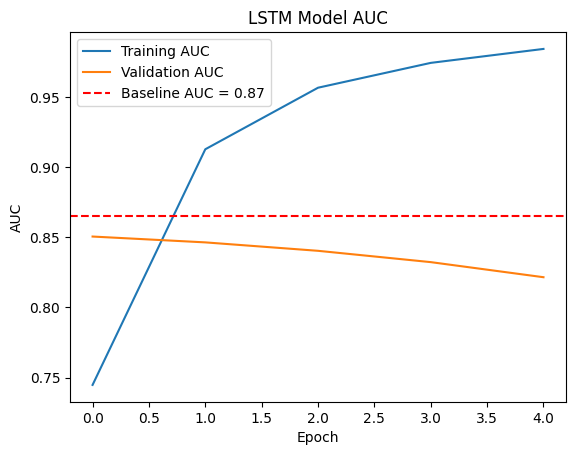

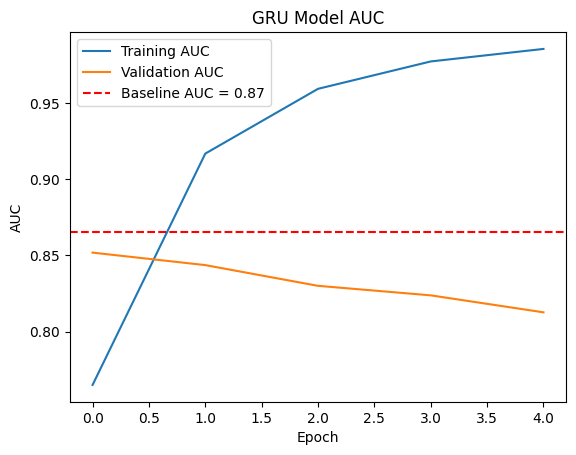

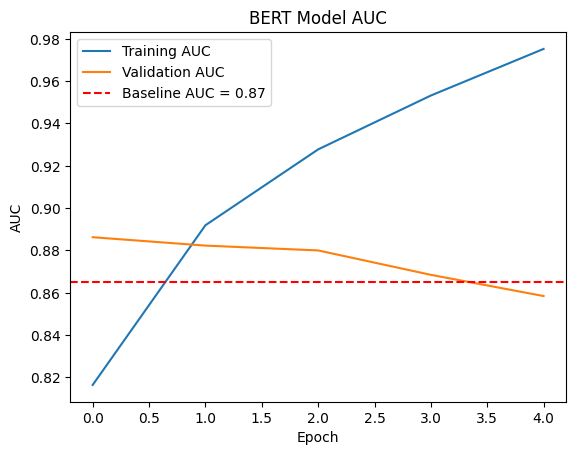

In [38]:
auc_tf_idf = roc_auc_score(y_val_tfidf, lr.predict_proba(X_val_tfidf)[:, 1])

def plot_auc(model, title):
    plt.plot(model.history['auc'], label='Training AUC')
    plt.plot(model.history['val_auc'], label='Validation AUC')
    plt.axhline(y=auc_tf_idf, color='r', linestyle='--', label=f'Baseline AUC = {auc_tf_idf:.2f}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

plot_auc(lstm, 'LSTM Model AUC')
plot_auc(gru, 'GRU Model AUC')
plot_auc(bert, 'BERT Model AUC')

In [37]:
from sklearn.metrics import roc_auc_score

y_pred_lstm = lstm_model.predict(X_val_lg).ravel()
y_pred_gru = gru_model.predict(X_val_lg).ravel()
y_pred_bert = bert_model.predict(X_val_bert_processed).ravel()

auc_lstm = roc_auc_score(y_val_lg, y_pred_lstm)
auc_gru = roc_auc_score(y_val_lg, y_pred_gru)
auc_bert = roc_auc_score(y_val_bert, y_pred_bert)

print(f"TF-IDF + LR ROC-AUC: {auc_tf_idf}")
print(f"LSTM Model ROC-AUC: {auc_lstm}")
print(f"GRU Model ROC-AUC: {auc_gru}")
print(f"BERT Model ROC-AUC: {auc_bert}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step 
TF-IDF + LR ROC-AUC: 0.8652707819812095
LSTM Model ROC-AUC: 0.8227074625799307
GRU Model ROC-AUC: 0.8133426213696282
BERT Model ROC-AUC: 0.8633372628871503


Among all the models evaluated, the BERT-based classifier exhibited the most impressive performance, reaching a peak validation ROC-AUC of *0.886*, which is higher than our baseline of *0.865* (TF-IDF + Logistic Regression). Although the LSTM and GRU models initially performed well, they soon began to overfit — their training AUCs increased consistently while validation AUCs declined, indicating a lack of generalization.

The traditional TF-IDF model, despite its simplicity, remained competitive and resilient. Nevertheless, BERT not only outperformed it but also delivered more consistent results throughout the epochs.

In light of these results, we choose BERT for further optimization, due to its superior performance and its ability to generalize effectively on unseen data.

## 7. Hyperparameter Tuning for BERT

We tune the following hyperparameters using Keras Tuner:
- Dense units: 64–512;
- Dropout rate: 0.3–0.7;
- Learning rate: 1e-5, 2e-5, 3e-5.

In [39]:
from keras_tuner import RandomSearch
from tensorflow.keras import optimizers

def build_bert_model_tuned(hp):
    token_ids = layers.Input(shape=(MAX_INPUT_LENGTH,), dtype=tf.int32, name='token_ids')
    segment_ids = layers.Input(shape=(MAX_INPUT_LENGTH,), dtype=tf.int32, name='segment_ids')
    padding_mask = layers.Input(shape=(MAX_INPUT_LENGTH,), dtype=tf.int32, name='padding_mask')

    bert_backbone = keras_nlp.models.BertBackbone.from_preset('bert_base_en_uncased')
    bert_backbone.trainable = True

    bert_outputs = bert_backbone({
        'token_ids': token_ids,
        'segment_ids': segment_ids,
        'padding_mask': padding_mask})
    cls_token = bert_outputs["pooled_output"]

    x = layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu')(cls_token)
    x = layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[token_ids, segment_ids, padding_mask], outputs=output)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-5, 2e-5, 3e-5])),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')])

    return model

tuner = RandomSearch(
    build_bert_model_tuned,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='bert_tuning',
    project_name='disaster_tweet')

tuner.search(
    x={
        'token_ids': X_bert_processed['token_ids'],
        'segment_ids': X_bert_processed['segment_ids'],
        'padding_mask': X_bert_processed['padding_mask']},
    y=y_train_bert,
    validation_data=({
        'token_ids': X_val_bert_processed['token_ids'],
        'segment_ids': X_val_bert_processed['segment_ids'],
        'padding_mask': X_val_bert_processed['padding_mask']},
        y_val_bert),
    epochs=5,
    batch_size=32)

Trial 10 Complete [03h 39m 46s]
val_auc: 0.8877317309379578

Best val_auc So Far: 0.8910093307495117
Total elapsed time: 22h 26m 45s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
print(f"Best Hyperparameters: {best_hyperparams.values}")

Best Hyperparameters: {'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 3e-05}


/Users/yaroslavilichenko/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 408 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
bert_best = best_model.fit(
    x={
        'token_ids': X_bert_processed['token_ids'],
        'segment_ids': X_bert_processed['segment_ids'],
        'padding_mask': X_bert_processed['padding_mask']},
    y=y_train_bert,
    validation_data=({
        'token_ids': X_val_bert_processed['token_ids'],
        'segment_ids': X_val_bert_processed['segment_ids'],
        'padding_mask': X_val_bert_processed['padding_mask']},
        y_val_bert),
    epochs=5,
    batch_size=32)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - auc: 0.9485 - loss: 0.2705 - val_auc: 0.8766 - val_loss: 0.5463
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 992s 5s/step - auc: 0.9807 - loss: 0.1704 - val_auc: 0.8706 - val_loss: 0.5904
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 976s 5s/step - auc: 0.9911 - loss: 0.1116 - val_auc: 0.8684 - val_loss: 0.6717
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 973s 5s/step - auc: 0.9940 - loss: 0.0890 - val_auc: 0.8473 - val_loss: 0.8501
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1133s 6s/step - auc: 0.9944 - loss: 0.0877 - val_auc: 0.8612 - val_loss: 0.7378


In [ ]:
y_pred_bert_best = best_model.predict({
    'token_ids': X_val_bert_processed['token_ids'],
    'segment_ids': X_val_bert_processed['segment_ids'],
    'padding_mask': X_val_bert_processed['padding_mask']
})
bert_auc_score = roc_auc_score(y_val_bert, y_pred_bert_best)
print(f"BERT Best Model ROC-AUC: {bert_auc_score:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step 
BERT Best Model ROC-AUC: 0.8667


Thus, we could improve the final ROC-AUC value on the validation set *only insignificantly* but the hyperparameter tuning can be still considered successful. This can be also observed on the following plot:

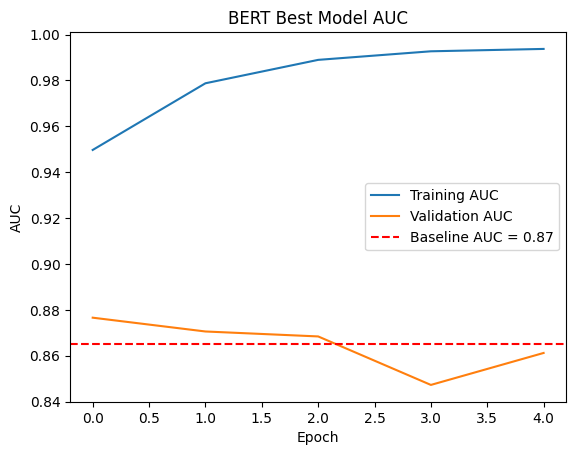

In [ ]:
plot_auc(bert_best, 'BERT Best Model AUC')

## 8. Generating Submission File

We select the tuned BERT model for generating the final submission:

In [75]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
test_encodings = tokenizer(
    test_df['text_preprocessed'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=MAX_INPUT_LENGTH,
    return_tensors='np')

test_preds = best_model.predict({
    'token_ids': test_encodings['input_ids'],
    'segment_ids': test_encodings['token_type_ids'],
    'padding_mask': test_encodings['attention_mask']})

102/102 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step


In [79]:
preds = (test_preds.flatten() >= 0.5).astype(int)

submission_df = pd.DataFrame({'id': test_df['id'], 'target': preds})
submission_df.to_csv('submission.csv', index=False)

## 9. Conclusion
In this study, we created and trained 4 models, a baseline model using TF-IDF with Logistic Regression, an LSTM model, a GRU model, a BERT model, and evaluate their results. While our classical baseline performed competitively, the BERT model showed more robust contextual understanding of text and made more meaningful probability predictions. Therefore, we selected BERT for hyperparameter tuning. With tuned parameters, we further improved the ROC-AUC performance. In the context of this project, the main objective was successfully accomplished. However, more could be considered in the following iterations, e.g.:
- deeper cleanup and usage of metadata (like `location`),
- leveraging semi-supervised learning with pseudo-labels,
- applying advanced tuning techniques such as Bayesian optimization or learning rate schedules.

## 10. References

- Geena Kim. DTSA 5511 Introduction to Deep Learning
- Geeksforgeeks. LSTM: https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
- Geeksforgeeks. GRU Networks: https://www.geeksforgeeks.org/gated-recurrent-unit-networks/
- Datacamp. What is BERT? An Intro to BERT Models: https://www.datacamp.com/blog/what-is-bert-an-intro-to-bert-models